## Particle within radius or overlap calculations

In [1]:
#user-defined
# import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [19]:
dir_save = '../../data/Sprints/AN/'
# dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_InterpolatedX.hdf'
dir1 = '~/Documents/MyFiles/DataAnalysis/data/Sprints/'
run01='Run01/Run01_expected_full.hdf'
run02='Run02/Run02_expected_full.hdf'
# run03='Run03Coll03_expected_full.hdf'
# run01='Run01.h5'
df1=pd.read_hdf(dir1+run01)
df2=pd.read_hdf(dir1+run02)
# df3=pd.read_hdf(dir1+run03)

### Calculate Expected encounters

In [50]:
df = pd.DataFrame()
df = pd.read_hdf(dir)
dt= df.master_time[1]-df.master_time[0]

In [51]:
# sync_time = df.master_time-df.master_time[0]
# df.insert(1,'sync_time',sync_time)

In [52]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
source = np.array([[0,0]])
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

### Finding Intersection area

In [ ]:
t1 = 'sync_time>=0 & sync_time<60'
d1=pd.DataFrame()
d1 = df.query(t1)

t2= 'sync_time>=60 & sync_time<120'
d2=pd.DataFrame()
d2 = df.query(t2)

t3= 'sync_time>=120 & sync_time<180'
d3=pd.DataFrame()
d3 = df.query(t3)

t4 = 'sync_time>=180 & sync_time<240'
d4=pd.DataFrame()
d4 = df.query(t4)

t5 = 'sync_time>=240 & sync_time<300'
d5=pd.DataFrame()
d5 = df.query(t5)

e1 = [np.sum(df.U[j:])*dt for j in range(d1.index[0],d1.index[-1])]
n1 = [np.sum(df.V[j:])*dt for j in range(d1.index[0],d1.index[-1])]

e2 = [np.sum(df.U[j:])*dt for j in range(d2.index[0],d2.index[-1])]
n2 = [np.sum(df.V[j:])*dt for j in range(d2.index[0],d2.index[-1])]

e3 = [np.sum(df.U[j:])*dt for j in range(d3.index[0],d3.index[-1])]
n3 = [np.sum(df.V[j:])*dt for j in range(d3.index[0],d3.index[-1])]

e4 = [np.sum(df.U[j:])*dt for j in range(d4.index[0],d4.index[-1])]
n4 = [np.sum(df.V[j:])*dt for j in range(d4.index[0],d4.index[-1])]

e5 = [np.sum(df.U[j:])*dt for j in range(d5.index[0],d5.index[-1])]
n5 = [np.sum(df.V[j:])*dt for j in range(d5.index[0],d5.index[-1])]

In [78]:
from scipy.spatial import cKDTree

# Assuming a default tolerance value of 1 here
def intersect_close(a, b, tol=0.05):
    # Get closest distances for each pt in b
    dist, index = cKDTree(a).query(b, k=1) # k=1 selects closest one neighbor

    # Check the distances against the given tolerance value and 
    # thus filter out rows off b for the final output
    return b[dist <= tol], index

In [80]:
c1 = np.column_stack((e1, n1))
c2 = np.column_stack((e2, n2))
test,index = intersect_close(c1,c2)
print(test)
a,b=zip(*test)

In [83]:
itemindex1 = np.where(np.isclose(e1, -182.85755155, atol=0.05))
itemindex2 = np.where(np.isclose(e2, -182.84417644, atol=0.05))
up1 = np.where(np.isclose(n1, 381.39412315, atol=0.05))
up2 = np.where(np.isclose(n2, 381.37677077, atol=0.05))

array([[-182.85755155,  381.39412315],
       [-182.85084279,  381.38545944],
       [-182.84417644,  381.37677077]])

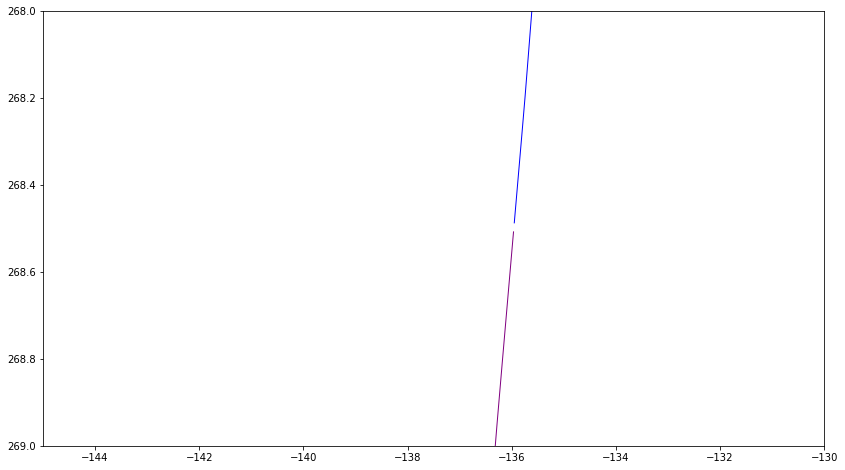

In [155]:
f= plt.figure(figsize=(14,8))
plt.xlim(-145,-130)
plt.ylim(269,268)
# n=-1
plt.plot(e1,n1, color='red', linewidth=1)
plt.plot(e2,n2, color='purple', linewidth=1)
# plt.plot(a,b, marker='+', linewidth=1)
plt.plot(e3,n3, color='blue',  linewidth=1)
plt.plot(e4,n4, color='orange',  linewidth=1)
plt.plot(e5,n5, color='green', linewidth=1)

### Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2

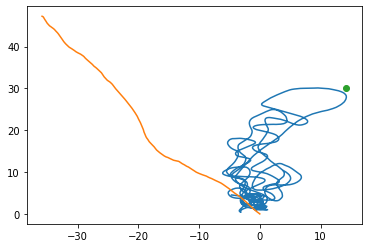

In [73]:
plt.plot(df.xsrc, df.ysrc)
plt.plot(eastwest[-6000:],northsouth[-6000:])
plt.plot(14.26531238518209, 30.115240559630987, marker='o', linewidth=15)

In [74]:
#summation till Nth particle
eastwest = [np.sum(df.U[j:])*dt for j in range(0,5000) ]
# northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

In [7]:
odor_presence=[]
min_distance = []
max_radius = []

#for(upper, lower, step)
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
        max_radius.append(0)
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        radius = np.arange(start = i, stop = 0, step = -1)**0.5*0.01
        max_radius.append(i**0.5*0.1)
    #TODO: Model better radius
    #max_radius= np.max(radius)
    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    min_distance.append(np.min(distance))
    #distance = distance[distance(distance<max_radius)]     #this step can reduce computation but arises issues 
                                                           #for different length arrays for distance and radius
    
    #TODO: Find a way to reduce distance array size and compare without increasing the overall execution time
    
    ## NOTE : COMPARING EVERY DISTANCE TO THE CORRESPONDING RADIUS TO SEE IF THE DISTANCE IS LESSER THAN 
    ## THE RADIUS WHICH WOULD MEAN THE PARTICLES MATCH. IF NOT THEN THEY DON'T MATCH FOR TIME T.
    
    ## comparing element to element, i.e. radius to corresponding distance
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [8]:
## flip containers because above iteration is done in reverse order
# _mock=np.zeros(len(df))
df['mock'] = np.zeros(len(df))
min_distance = np.array(np.flip(min_distance)) 
odor_presence = odor_presence[::-1]
max_radius = max_radius[::-1]
## storing in the dataframe 
df['odor_expected'] = odor_presence
df['odor_from_wind'] = distance_from_source
df['odor_from_source'] = min_distance
df['radius'] = max_radius

# sensor_direction = np.array(np.arctan2(df.gps_linear_y,df.gps_linear_x)* 180 / np.pi)
# df['relative_motion']=sensor_direction - df.D

## Visualization

In [11]:
query = 'odor>=2'
df_occurence = df.query(query)
query1='odor<2'
df_no_occurence = df.query(query1)


x = np.linspace(0,35,12)
y = np.linspace(0,18,10)
H1, x, y = np.histogram2d(df.odor_from_source, df.odor_from_wind, bins=(x, y))
H1 = H1.T 
# plt.imshow(H, interpolation='nearest', origin='lower',cmap = 'BuPu', extent=[x[0], x[-1], y[0], y[-1]])

H2, x, y = np.histogram2d(df_occurence.odor_from_source, df_occurence.odor_from_wind, bins=(x, y))
H2 = H2.T 

H3, x, y = np.histogram2d(df_no_occurence.odor_from_source, df_no_occurence.odor_from_wind, bins=(x, y))
H3 = H3.T


Encounters = np.array(H2)/np.array(H1)
Encounters[Encounters == np.inf] = 0

<ipython-input-11-e6488ab4e57d>:20: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(H2)/np.array(H1)


In [ ]:

query2 = 'odor>=2'
df2_occurence = df2.query(query2)
query3='odor<2'
df2_no_occurence = df2.query(query3)


x = np.linspace(0,35,12)
y = np.linspace(0,18,10)
H4, x, y = np.histogram2d(df2.odor_from_source, df2.odor_from_wind, bins=(x, y))
H4 = H4.T 
# plt.imshow(H, interpolation='nearest', origin='lower',cmap = 'BuPu', extent=[x[0], x[-1], y[0], y[-1]])

H5, x, y = np.histogram2d(df2_occurence.odor_from_source, df2_occurence.odor_from_wind, bins=(x, y))
H5 = H5.T 

H6, x, y = np.histogram2d(df2_no_occurence.odor_from_source, df2_no_occurence.odor_from_wind, bins=(x, y))
H6 = H6.T

Encounters = np.array(H2+H5)/np.array(H1+H4)
Encounters[Encounters == np.inf] = 0

No_Encounters = np.array(H3+H6)/np.array(H1+H4)
No_Encounters[No_Encounters == np.inf] = 0

In [40]:
Total = H1
N_Encounter = H2

## removing areas less than 1000 deno

for i in range (len(Total)):
    for j in range(len(Total[i])):
        if Total[i][j]<4000:
            Total[i][j] =0
            N_Encounter[i][j]=0

E = np.array(N_Encounter)/np.array(Total)
E[E == np.inf] = 0

<ipython-input-40-f85ea9a239bc>:12: RuntimeWarning: invalid value encountered in true_divide
  E = np.array(N_Encounter)/np.array(Total)


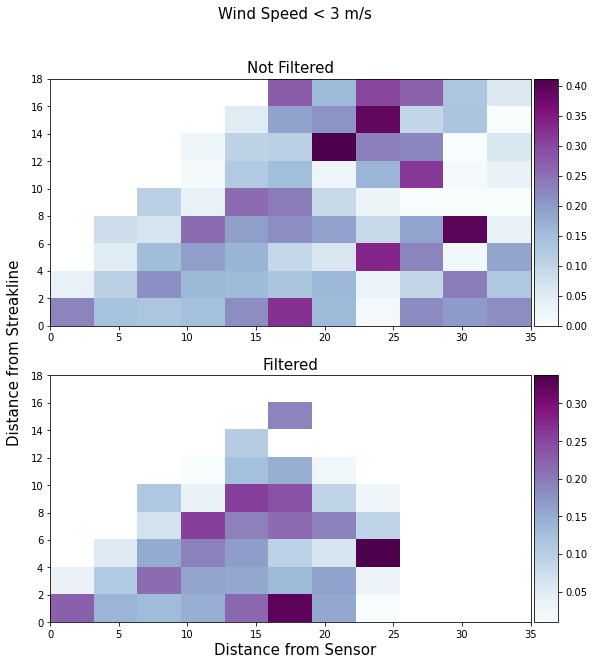

In [41]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(10,10) , gridspec_kw={'height_ratios': [4,4]})
f.suptitle('Wind Speed < 3 m/s', fontsize = 15)
var = ax1.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'BuPu', extent=[x[0], x[-1], y[0], y[-1]])
ax1.set_title('Not Filtered', fontsize = 15)
start, end = ax1.get_xlim()
divider = make_axes_locatable(ax1)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax0, orientation = 'vertical')

var2 = ax2.imshow(E, interpolation='nearest', origin='lower',cmap = 'BuPu', extent=[x[0], x[-1], y[0], y[-1]])
ax2.set_title('Filtered', fontsize = 15)
start, end = ax2.get_xlim()
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax1, orientation = 'vertical')
f.text(0.5, 0.08, 'Distance from Sensor', ha='center', fontsize = 15) 
f.text(0.1, 0.5, 'Distance from Streakline', fontsize = 15, va='center', rotation='vertical')

# f.savefig(dir_save+'ProbDistNonWindyGlobal.jpeg')